In [29]:
%matplotlib inline
# -*- coding: utf-8 -*-
"""
Exemple de réseau de neuronne à propagation avant et
rétropropagation de l'erreur pour l'apprentissage
"""
import random
import numpy as np
np.random.seed(42) # pour reproduire les mêmes résultats
random.seed(42)
import matplotlib.pyplot as plt

def sigmoide(z):
    """The sigmoide function."""
    return 1.0/(1.0+np.exp(-z))

def derivee_sigmoide(z):
    """Derivative of the sigmoide function."""
    return sigmoide(z)*(1-sigmoide(z))

def bitmap(classe):
    """ Representer l'entier de classe par un vecteur bitmap (10,1) 
    classe : entier entre 0 et 9 qui représente la classe de l'observation"""
    e = np.zeros((10, 1))
    e[classe] = 1.0
    return e

class RNA(object):
    """ Un RNA est un réseau de neuronnes artificiel multi-couche.
    """
        
    def __init__(self, ncs):
        """ ncs[c] contient le nombre de neurones de la couche c, c = 0 ...nombre_couches-1
        la couche d'indice 0 est la couche d'entrée
        ncs[nombre_couches-1] doit correspondre au nombre de catégories des y (sortie)
        
        liste_w[c] est la matrice des poids entre la couche c et c+1
        liste_w[c][i,j] est le poids entre le neuronne i de la couche c+1 et j de la couche c
        i = 0 correspond au biais par convention
        les poids sont initialisés avec un nombre aléatoire selon une distribution N(0,1)
        """
        self.nombre_couches = len(ncs)
        self.ncs = ncs
        self.liste_w = [np.random.randn(x+1,y) for x, y in zip(ncs[:-1], ncs[1:])]

    def propagation_avant_w(self, activation):
        """
        Traiter une entrée par propagation avant
        
        activation: activation initiale qui correspond aux entrées (taille self.ncs[0])
        retourne l'activation de sortie après propagation avant"""
        
        for w in self.liste_w:
            activation = np.vstack((np.ones(1),sigmoide(np.dot(w.transpose(),activation))))
        return activation

    def entrainer_par_mini_lot(self,donnees_entrainement,donnees_test,nombre_epochs,taille_mini_lot,eta):
        """
        Entrainer le RNA par mini-lots
        Affiche le nombre de bons résultats des donnees_test pour chaque epoch
        
        donnees_entrainement : liste de tuples (x,y) pour l'entrainement où
            x est un tableau de taille (ncs[0],1) où n est la taille des entrées
            y est un encodage bitmap de la catégorie en tableau de taille ncs[nombre_couches-1]
        donnees_test : liste de tuples (x,y) pour les tests
            x est un tableau de taille (ncs[0],1) où n est la taille des entrées
            y un int où 0<=y< nombre de catégories
        nombre_epochs : nombre de passe d'entrainement
        taille_mini_lot : la taille de chacun des mini-lots
        eta : vitesse d'apprentissage
        """
        n_test = len(donnees_test)
        n_ent = len(donnees_entrainement)
        self.liste_eqm_ent = []
        self.liste_abs_ent = []
        self.liste_eqm_test = []
        self.liste_abs_test = []
        
        for j in range(nombre_epochs):
            random.shuffle(donnees_entrainement)
            mini_lots = [donnees_entrainement[k:k+taille_mini_lot] for k in range(0, n_ent, taille_mini_lot)]
            # Entrainer un mimi-lot à la fois
            for mini_lot in mini_lots:
                # Initialiser les gradiants totaux à 0
                liste_dJ_dw = [np.zeros(w.shape) for w in self.liste_w]
                for x, y in mini_lot:
                    dJ_dw_une_ligne = self.retropropagation_w(x, y)
                    # ajouter les gradiants d'une observation aux totaux partiels du lot
                    liste_dJ_dw = [dJ_dw+dJ_dw_1 for (dJ_dw, dJ_dw_1) in zip(liste_dJ_dw, dJ_dw_une_ligne)]
                # mettre à jour les paramètres du RNA avec les gradiants du lot    
                self.liste_w = [w-(eta/len(mini_lot))*dw  for (w, dw) in zip(self.liste_w, liste_dJ_dw)]
            
             # Calcul des métriques de performance
            eqm_ent,abs_ent = self.metriques(donnees_entrainement)
            eqm_test,abs_test = self.metriques(donnees_test)
            self.liste_eqm_ent.append(eqm_ent/n_ent)
            self.liste_abs_ent.append(abs_ent/n_ent)
            self.liste_eqm_test.append(eqm_test/n_test)
            self.liste_abs_test.append(abs_test/n_test)
            print("Epoch {0}: EQM entrainement: {1} Erreur absolue: {2}".format(j, eqm_ent/n_ent,abs_ent/n_ent))
            print("Epoch {0}: EQM test: {1} Erreur absolue: {2}".format(j, eqm_test/n_test,abs_test/n_test))

        # Affichage des graphiques d'évolution des performances par epoch
        plt.plot(np.arange(0,nombre_epochs),self.liste_eqm_ent,label='Eqm entraînement')
        plt.plot(np.arange(0,nombre_epochs),self.liste_eqm_test,label='Eqm test')
        plt.title("Erreur quadratique moyenne")
        plt.xlabel('epoch')
        plt.ylabel('erreur')
        plt.legend(loc='upper center')
        plt.show()

        plt.plot(np.arange(0,nombre_epochs),self.liste_abs_ent,label='Erreur absolue entraînement')
        plt.plot(np.arange(0,nombre_epochs),self.liste_abs_test,label='Erreur absolue test')
        plt.title("Erreur absolue")
        plt.xlabel('epoch')
        plt.ylabel('nb correct')
        plt.legend(loc='upper center')
        plt.show()
    
    def retropropagation_w(self, x, y):
        """Return a tuple ``(dJ_db, dJ_dw)`` representing the
        gradient for the cost function C_x.  ``dJ_db`` and
        ``dJ_dw`` are layer-by-layer lists of numpy arrays, similar
        to ``self.liste_biais`` and ``self.liste_w``."""
        dJ_dw = [np.zeros(w.shape) for w in self.liste_w]

        # propagation_avant
        activation = np.vstack((np.ones(1),x)) # activation
        activations = [np.vstack((np.ones(1),x))] # liste des activations couche par couche
        zs = [] # liste des z par couche
        for w in self.liste_w:
            z = np.dot(w.transpose(),activation)
            zs.append(z)
            activation = np.vstack((np.ones(1),sigmoide(z))) 
            activations.append(activation)
        
        # retropropagation
        dJ_dz = self.dJ_da_final(activations[-1][1:], y)*derivee_sigmoide(zs[-1])
        dJ_dw[-1] = np.dot(activations[-2],dJ_dz.transpose())
        # itérer de la couche nc-2 à la couche 1
        for l in range(2, self.nombre_couches):
            z = zs[-l]
            sp = derivee_sigmoide(z)
            dJ_dz = np.dot(self.liste_w[-l+1], dJ_dz)[1:] * sp
            dJ_dw[-l] = np.dot(activations[-l-1], dJ_dz.transpose())
        return dJ_dw

    def metriques(self, donnees):
        """Métriques pour régression"""
        erreur_quadratique = 0
        erreur_absolu = 0
        for (x,y) in donnees:
            resultat_propagation = self.propagation_avant_w(np.vstack((np.ones(1),x)))[1:]
            erreur_quadratique += sum((resultat_propagation-y)**2)
            erreur_absolu += sum(abs(resultat_propagation-y))
        return (erreur_quadratique,erreur_absolu)

    def dJ_da_final(self, output_activations, y):
        """Dérivée de J par rapport à l'activation"""
        return (output_activations-y)

def diviser_ent_test(donnees, proportion):
    """ Diviser aléatoirement les données en deux groupes, entrainement et test
    proportion : proportion des données de test"""
    random.shuffle(donnees)
    taille_test = int(len(donnees) * proportion)
    return donnees[:taille_test],donnees[taille_test:]

def bitmap2(classe):
    """ Representer l'entier de classe par un vecteur bitmap (10,1) 
    classe : entier entre 0 et 9 qui représente la classe de l'observation"""
    e = np.zeros((2, 1))
    e[classe] = 1.0
    return e

theta0_estime = 5.5274658287008736  theta1_estime =  0.9486997944551838
Erreur quadratique moyenne: 0.8376914371160101


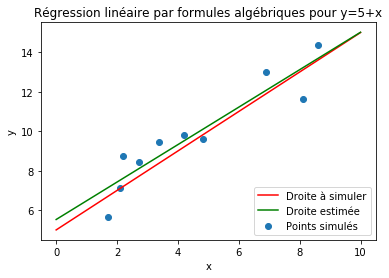

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def h_lineaire_univarie(theta,x):
    return theta[0]+theta[1]*x
def eqm(Y_estime,Y,m):
    return (((Y_estime-Y)**2).sum())*1/m

# Génération de données qui suivent une distribution linéaire univariée avec résidus ~ N(0,1)
m=10 # nombre de lignes de données
theta_simule = (5,1)
np.random.seed(22) # Pour obtenir des résultats reproductibles avec les données aléatoires

X = np.random.rand(m)*m # m valeurs de x entre 0 et m
Y = h_lineaire_univarie(theta_simule,X)+np.random.randn(m) # Résidus N(0,1)
plt.scatter(X,Y,label = 'Points simulés') # Pour afficher les données aléatoires simulées



# Pour afficher la droite du modèle simulé
X_modele = np.arange(0,m+1,1) 
Y_modele = h_lineaire_univarie(theta_simule,X_modele)
plt.plot(X_modele, Y_modele,'-r',label = 'Droite à simuler')

# Calculer les estimations de theta par les formules dérivées algébriquement
X_bar = X.sum()/m
Y_bar = Y.sum()/m
CovXY = (((X-X_bar)*(Y-Y_bar)).sum())/m
VarX = (((X-X_bar)**2).sum())/m
theta1_estime = CovXY/VarX
theta0_estime = Y_bar-theta1_estime*X_bar
print("theta0_estime =",theta0_estime," theta1_estime = ",theta1_estime)

Y_estime = theta0_estime + theta1_estime*X # Valeurs estimées pour X
print("Erreur quadratique moyenne:", eqm(Y_estime,Y,m))

# Pour afficher la droite de régression estimée
Y_droite_estimee =  theta0_estime + theta1_estime*X_modele # Valeurs estimées pour X_modele
plt.plot(X_modele, Y_droite_estimee, '-g',label = 'Droite estimée')

plt.title("Régression linéaire par formules algébriques pour y=5+x")
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='lower right')
plt.show()


In [24]:
donnees = [(np.reshape(X[i],(1,1)),np.reshape(Y[i],(1,1))) for i in range(len(X))]
donnees_test,donnees_ent=diviser_ent_test(donnees, 0.5)

Epoch 0: EQM entrainement: [61.61576115] Erreur absolue: [7.57641621]
Epoch 0: EQM test: [107.79405046] Erreur absolue: [10.14648195]
Epoch 1: EQM entrainement: [61.00357657] Erreur absolue: [7.53751321]
Epoch 1: EQM test: [106.91737518] Erreur absolue: [10.10435392]
Epoch 2: EQM entrainement: [60.74418029] Erreur absolue: [7.52074404]
Epoch 2: EQM test: [106.55299459] Erreur absolue: [10.08674174]
Epoch 3: EQM entrainement: [60.62274765] Erreur absolue: [7.51260215]
Epoch 3: EQM test: [106.39219959] Erreur absolue: [10.07874451]
Epoch 4: EQM entrainement: [60.55200952] Erreur absolue: [7.50776065]
Epoch 4: EQM test: [106.30189902] Erreur absolue: [10.07417959]
Epoch 5: EQM entrainement: [60.50450297] Erreur absolue: [7.50447641]
Epoch 5: EQM test: [106.24236904] Erreur absolue: [10.07114861]
Epoch 6: EQM entrainement: [60.47016939] Erreur absolue: [7.50208769]
Epoch 6: EQM test: [106.19986369] Erreur absolue: [10.06897556]
Epoch 7: EQM entrainement: [60.44430923] Erreur absolue: [7.50

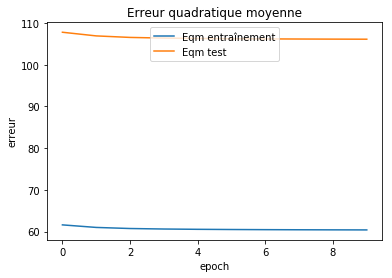

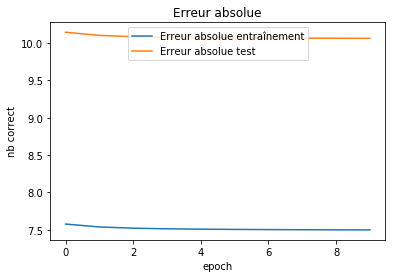

In [31]:
un_rna = RNA([1,2,1])
un_rna.entrainer_par_mini_lot(donnees_ent,donnees_test,10,1,0.1)